In [1]:
# Import necessary libraries
import os
import numpy as np
import cv2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
!pip install xgboost


     ------------------------------------ 124.9/124.9 MB 227.4 kB/s eta 0:00:00


In [2]:
# Dataset directories
data_dir = r'D:\PFE\D2\balanced_dataset'  # Main dataset directory
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
validation_dir = os.path.join(data_dir, "validation")


In [3]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7  # Number of classes in the dataset


In [4]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Background removal using color thresholding
def remove_background_color_thresholding(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])  # Lower bound for green in HSV
    upper_green = np.array([85, 255, 255])  # Upper bound for green in HSV
    mask = cv2.inRange(hsv, lower_green, upper_green)
    mask_inv = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(image, image, mask=mask_inv)
    return result


In [5]:
# Modified Data Loading to include Binary Labels
def load_data_binary(data_dir, apply_clahe_flag=False, apply_color_thresholding=False):
    healthy_images, healthy_labels = [], []
    diseased_images, diseased_labels = [], []
    
    for label, class_dir in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            
            # Resize and normalize the image
            img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            
            # Apply CLAHE or color thresholding
            preprocessed_img = img_resized.copy()
            if apply_color_thresholding:
                preprocessed_img = remove_background_color_thresholding(preprocessed_img)
            if apply_clahe_flag:
                preprocessed_img = apply_clahe(preprocessed_img)
            
            # Classify as healthy or diseased (binary classification)
            if class_dir == "healthy":  # Assuming 'healthy' is a directory
                healthy_images.append(preprocessed_img / 255.0)
                healthy_labels.append(0)  # 0 for healthy
            else:
                diseased_images.append(preprocessed_img / 255.0)
                diseased_labels.append(1)  # 1 for not healthy (diseased)
    
    # Combine healthy and diseased images
    images = np.array(healthy_images + diseased_images)
    labels = np.array(healthy_labels + diseased_labels)
    
    return images, labels

In [6]:
# Binary classifier
def create_binary_model(input_shape):
    base_model = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(2, activation="softmax")(x)  # Binary output (healthy vs not healthy)
    model = Model(inputs=base_model.input, outputs=output)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Multi-class classifier (only for diseased images)
def create_multi_class_model(input_shape, num_classes=6):
    base_model = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)  # Multi-class output (6 diseases)
    model = Model(inputs=base_model.input, outputs=output)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
# Training Binary Classifier
X_train_binary, y_train_binary = load_data_binary(train_dir, apply_clahe_flag=True, apply_color_thresholding=True)
X_test_binary, y_test_binary = load_data_binary(test_dir, apply_color_thresholding=True)
X_val_binary, y_val_binary = load_data_binary(validation_dir, apply_color_thresholding=True)

# One-hot encode binary labels
y_train_binary = to_categorical(y_train_binary, 2)
y_test_binary = to_categorical(y_test_binary, 2)
y_val_binary = to_categorical(y_val_binary, 2)


In [8]:
# Create and train binary classification model
binary_model = create_binary_model((IMG_SIZE[0], IMG_SIZE[1], 3))
history_binary = binary_model.fit(X_train_binary, y_train_binary, validation_data=(X_val_binary, y_val_binary), epochs=35, batch_size=BATCH_SIZE)


Epoch 1/35


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


9/9 ━━━━━━━━━━━━━━━━━━━━ 283s 16s/step - accuracy: 0.7177 - loss: 0.6497 - val_accuracy: 0.8571 - val_loss: 0.4464
Epoch 2/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step - accuracy: 0.8569 - loss: 0.4480 - val_accuracy: 0.8889 - val_loss: 0.3261
Epoch 3/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.8613 - loss: 0.3576 - val_accuracy: 0.8571 - val_loss: 0.2961
Epoch 4/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 91s 10s/step - accuracy: 0.8590 - loss: 0.3419 - val_accuracy: 0.8571 - val_loss: 0.2822
Epoch 5/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - accuracy: 0.8821 - loss: 0.3095 - val_accuracy: 0.8571 - val_loss: 0.2807
Epoch 6/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - accuracy: 0.9038 - loss: 0.2595 - val_accuracy: 0.9048 - val_loss: 0.2549
Epoch 7/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 85s 9s/step - accuracy: 0.9387 - loss: 0.1901 - val_accuracy: 0.8889 - val_loss: 0.2537
Epoch 8/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 88s 10s/step - accuracy: 0.8654 - loss: 0.2849 - val_accuracy: 0.8730 - val_loss: 0.2568
Epoch 9/35
9/9 

In [9]:
# Evaluate the binary classifier
binary_test_loss, binary_test_accuracy = binary_model.evaluate(X_test_binary, y_test_binary)
print(f"Binary Classifier Test Accuracy: {binary_test_accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.9474 - loss: 0.1476
Binary Classifier Test Accuracy: 0.95


In [10]:
# Identify the "not healthy" images for multi-class classification
# Only images predicted as "not healthy" will go to the multi-class model
y_pred_binary = binary_model.predict(X_test_binary)
y_pred_binary_classes = np.argmax(y_pred_binary, axis=1)

# Filter out the diseased (not healthy) images and labels
diseased_images = X_test_binary[y_pred_binary_classes == 1]
diseased_labels = y_test_binary[y_pred_binary_classes == 1]



C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 43s/step


In [12]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the multi-class labels for diseases
diseased_labels_one_hot = to_categorical(diseased_labels, num_classes=6)

# Create the multi-class model
multi_class_model = create_multi_class_model((IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=6)

# Train the multi-class classifier
history_multi_class = multi_class_model.fit(diseased_images, diseased_labels_one_hot, epochs=45, batch_size=BATCH_SIZE)


Epoch 1/45


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1420']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.0837 - loss: 2.5654 
Epoch 2/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5796 - loss: 1.0739
Epoch 3/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8954 - loss: 0.4537
Epoch 4/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9644 - loss: 0.1466
Epoch 5/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9770 - loss: 0.1691
Epoch 6/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9874 - loss: 0.0906
Epoch 7/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9770 - loss: 0.2183
Epoch 8/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9874 - loss: 0.0947
Epoch 9/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9770 - loss: 0.1084
Epoch 10/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9770 - loss: 0.1229
Epoch 11/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9874 - loss: 0.0683
Epoch 12/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9770 - loss: 0.1123
Epoch 13/45
2/2 ━━━━━━━━━━━━━━━━━━

In [14]:
# Evaluate the multi-class model using one-hot encoded labels
multi_class_test_loss, multi_class_test_accuracy = multi_class_model.evaluate(diseased_images, diseased_labels_one_hot)
print(f"Multi-class Classifier Test Accuracy: {multi_class_test_accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 1.0000 - loss: 0.0063
Multi-class Classifier Test Accuracy: 1.00


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1420']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step


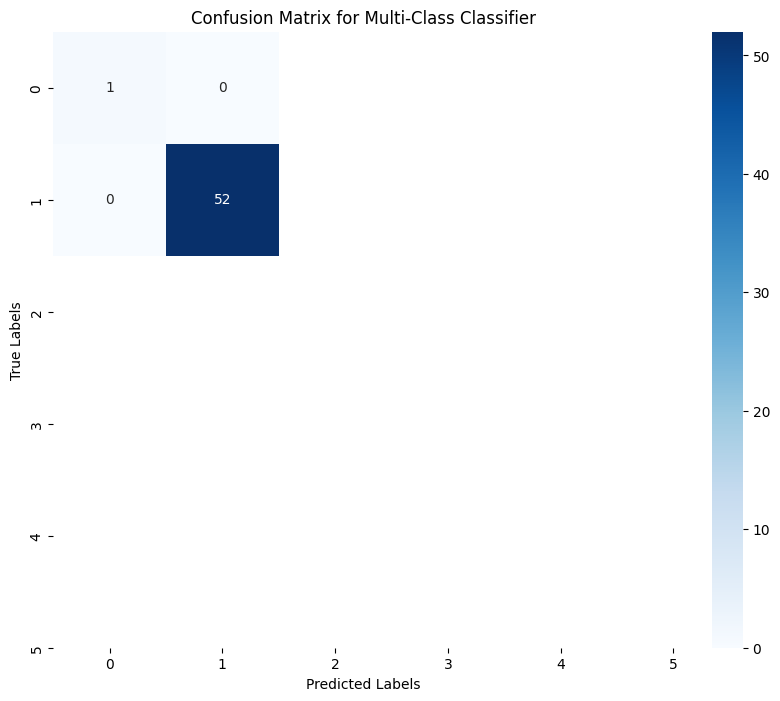

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the predictions from the model
y_pred = multi_class_model.predict(diseased_images)

# Convert the predictions to the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels back to class indices
y_true_classes = np.argmax(diseased_labels_one_hot, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Multi-Class Classifier")
plt.show()
